#### Попытки решить дифференциальное уравнение для затухаущего гармонического осциллятора при помощи PINN

$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$

с начальными условиями

$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$

Рассматриваем случай с малыми затуханиями

$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$

Точное решение

$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$

In [5]:
import time

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

def compute_grad_theta_norm(model):
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += param.grad.norm(2).item()**2
    return grad_norm ** 0.5

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.bias, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    #nn.init.zeros_(layer.bias)
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")

torch.manual_seed(2008)
device = 'cuda'

# Problem definition
""" --- ОДНОМЕРНЫЙ ЗАТУХАЮЩИЙ ГАРМОНИЧЕСКИЙ ОСЦИЛЛЯТОР ---
u'' + 2 * delta * u' + omega0^2 * u = 0, где delta = mu/(2m), omega0 = sqrt(k/m)   (случай с затуханиями: delta < omega0)
u(0)  = 1,
u'(0) = 0.
u_exact(t) = 2 * A * exp(-delta * t) * cos(phi + omega * t), 
где omega = sqrt(omega0^2 - delta^2), 
    phi   = arctg(-delta/omega), 
    A     = 1 / (2 * cos(phi))"""
delta, omega0 = 2, 20
domain = [0, 1]    # t_min, t_max

# Training parameters
n_points = 1000
n_epochs = 5000
lambda_ic, lambda_r = 10, 1
causal_m = 10
causal_eps = 1
grad_norm_weighting_freq=100000
grad_norm_weighting_alpha=0.9

# Model
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256), nn.Tanh(), 
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        n = self.net(x)
        return n #* x**2 * n + 1.0
model = MyNet().to(device)
initialize_weights(model, "glorot_normal")

#t_ic = torch.tensor([[float(domain[0])]], device=device, requires_grad=True)
t_ic = torch.rand((n_points, 1), device=device) * 1e-3
t_ic.requires_grad_(True)
t_r = torch.rand((n_points, 1), device=device, requires_grad=True)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1.0/10000))

loss_log = torch.zeros(n_epochs)
loss_r_log = torch.zeros(n_epochs)
loss_ic_log = torch.zeros(n_epochs)
lambda_r_log = [lambda_r]
lambda_ic_log = [lambda_ic]
W_log = dict()
L_t_log = dict()

pbar = trange(n_epochs)
for iter in pbar:
    optimizer.zero_grad()

    u_r = model(t_r)
    u_ic = model(t_ic)

    du_dt = torch.autograd.grad(u_r, t_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t_r, grad_outputs=torch.ones_like(du_dt), create_graph=True)[0]
    res_r = d2u_dt2 + 2*delta*du_dt + omega0*omega0*u_r
    res_ic1 = u_ic - torch.ones_like(u_ic)
    res_ic2 = torch.autograd.grad(u_ic, t_ic, grad_outputs=torch.ones_like(u_ic), create_graph=True)[0]

    #optimizer.zero_grad()
    loss_ic = torch.mean(res_ic1**2) + torch.mean(res_ic2**2)
    #if iter % grad_norm_weighting_freq == 0:
    #    loss_ic.backward(retain_graph=True)
    #    grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

    t_flat = t_r.detach().squeeze(-1)           # shape (N,)

    #optimizer.zero_grad()
    L_t = torch.zeros(causal_m, device=device)
    h = (domain[1] - domain[0]) / causal_m
    for i in range(causal_m):
        mask = ((i * h < t_flat) & (t_flat <= (i + 1) * h))
        if mask.any():
            L_t[i] = torch.mean(res_r[mask]**2)
        else:
            L_t[i] = 0.0
    M = torch.tril(torch.ones(causal_m, causal_m, device=device), diagonal=-1)
    W = torch.exp(-causal_eps * (M @ L_t)).detach()
    loss_r = (W * L_t).mean()
    #if iter % grad_norm_weighting_freq == 0:
    #    loss_r.backward(retain_graph=True)
    #   grad_loss_r_theta_norm = compute_grad_theta_norm(model)

    # if iter % grad_norm_weighting_freq == 0 and iter != 0:
    #     tmp = grad_loss_r_theta_norm + grad_loss_ic_theta_norm
    #     lambda_r = grad_norm_weighting_alpha*lambda_r + (1.0 - grad_norm_weighting_alpha) * tmp / grad_loss_r_theta_norm
    #     lambda_ic = grad_norm_weighting_alpha*lambda_ic + (1.0 - grad_norm_weighting_alpha) * tmp / grad_loss_ic_theta_norm

    loss = lambda_r * loss_r + lambda_ic * loss_ic

    loss.backward()
    optimizer.step()
    #scheduler.step()

    if iter % 200 == 0:
        W_log[iter] = W.detach().cpu()
        L_t_log[iter] = L_t.detach().cpu()
        
    if iter % 1 == 0:
        loss_log[iter] = loss.item()
        loss_r_log[iter] = loss_r.item()
        loss_ic_log[iter] = loss_ic.item()
        lambda_r_log.append(lambda_r)
        lambda_ic_log.append(lambda_ic)

    if iter % 100 == 0:
        pbar.set_postfix({
            'loss': loss.item(),
            'loss_r': loss_r.item(),
            'loss_ic': loss_ic.item(),
            'lambda_r': lambda_r,
            'lambda_ic': lambda_ic
        })

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:31<00:00, 54.71it/s, loss=10, loss_r=0.0047, loss_ic=1, lambda_r=1, lambda_ic=10]     


# Losses

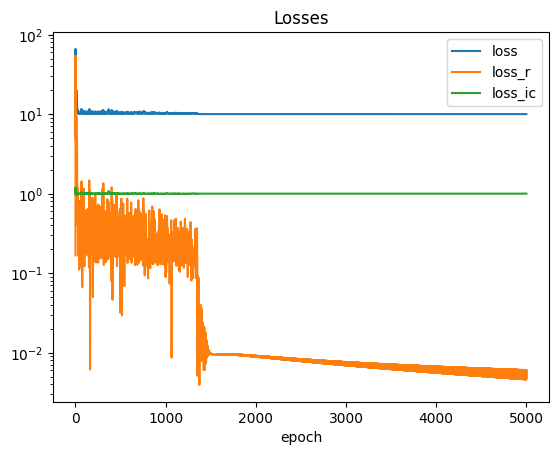

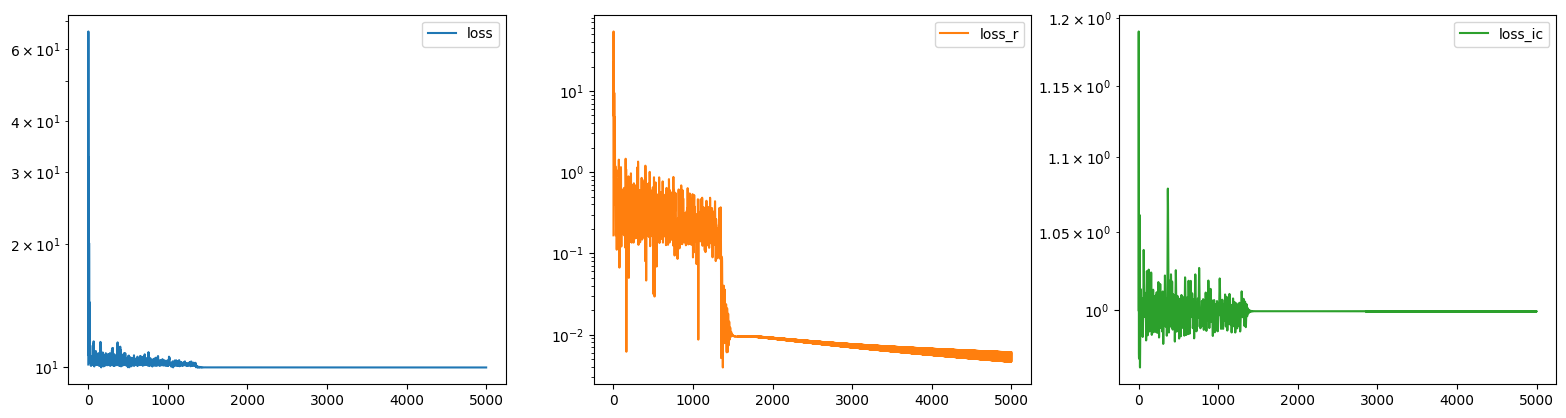

In [6]:
fig, ax = plt.subplots()
ax.set_title("Losses")
ax.set_xlabel("epoch")
ax.semilogy(loss_log, label="loss")
ax.semilogy(loss_r_log, label="loss_r")
ax.semilogy(loss_ic_log, label="loss_ic")
ax.legend()
plt.show()

w, h = plt.rcParams['figure.figsize']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*w, h))
ax1.semilogy(loss_log, label="loss", color='C0')
ax1.legend()
ax2.semilogy(loss_r_log, label="loss_r", color='C1')
ax2.legend()
ax3.semilogy(loss_ic_log, label="loss_ic", color='C2')
ax3.legend()
plt.show()

# Lambdas

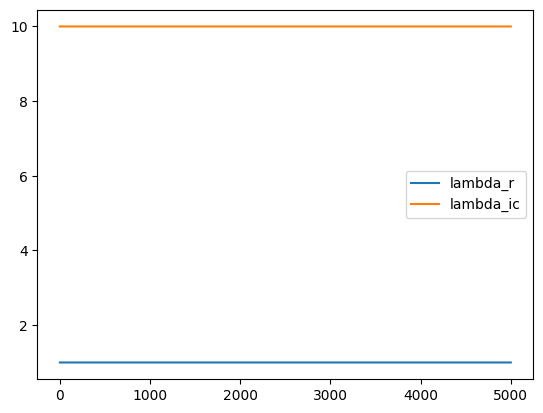

In [7]:
fig, ax = plt.subplots()
ax.plot(lambda_r_log, label="lambda_r")
ax.plot(lambda_ic_log, label="lambda_ic")
ax.legend()
plt.show()

# Temporal Weights

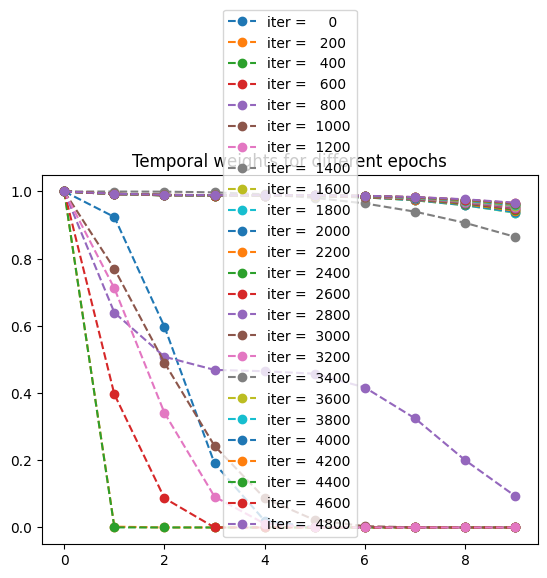

In [8]:
fig, ax = plt.subplots()
for iter, w in W_log.items():
    ax.plot(w, 'o--', label=f"iter = {iter:5d}")
ax.legend()
ax.set_title("Temporal weights for different epochs")
plt.show()

# L_t

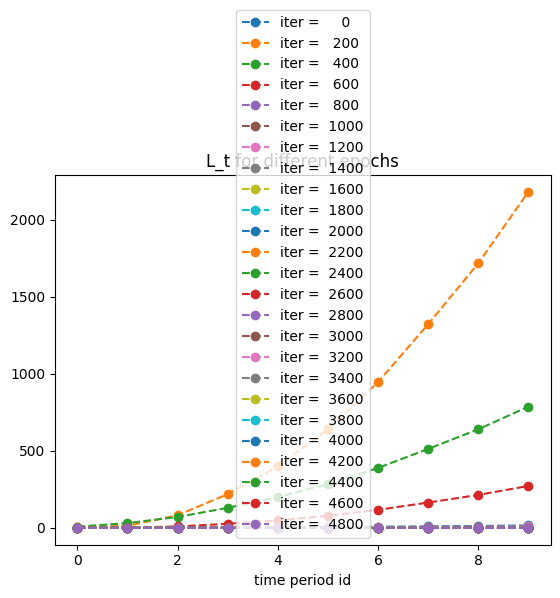

In [9]:
fig, ax = plt.subplots()
for iter, l in L_t_log.items():
    ax.plot(l, 'o--', label=f"iter = {iter:5d}")
ax.legend()
ax.set_xlabel("time period id")
ax.set_title("L_t for different epochs")
plt.show()

# Model vs reference solution

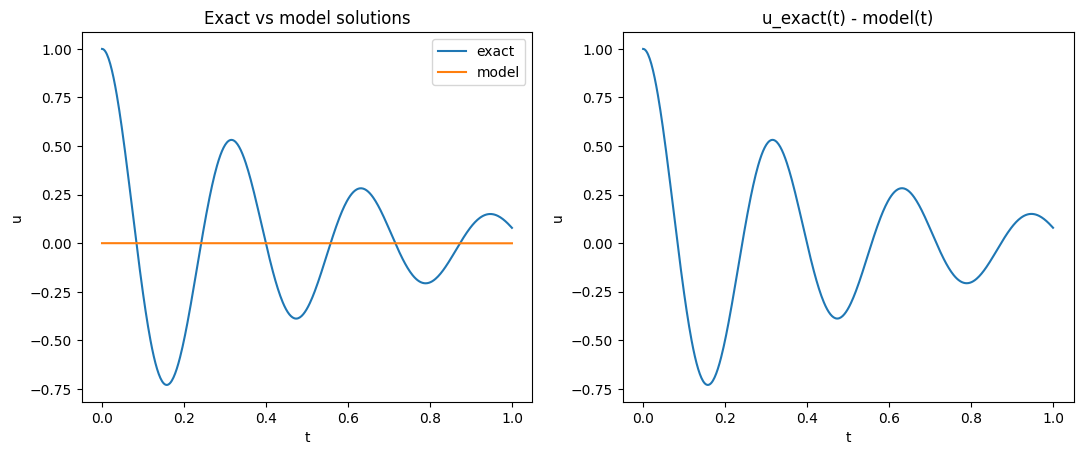

In [10]:
def oscillator(delta, omega0, t):
    assert delta < omega0
    omega = np.sqrt(omega0**2 - delta**2)
    phi = np.arctan(-delta / omega)
    A = 1.0 / ( 2.0 * np.cos(phi) )
    return 2.0 * A * torch.exp(-delta * t) * torch.cos(phi + omega * t)
u_exact = lambda t: oscillator(delta=delta, omega0=omega0, t=t)

with torch.no_grad():
    model = model.to("cpu")
    t = torch.linspace(*domain, 500).reshape(-1, 1)

    w, h = plt.rcParams['figure.figsize']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
    ax1.set_title("Exact vs model solutions")
    ax1.set_xlabel("t")
    ax1.set_ylabel("u")
    ax1.plot(t, u_exact(t), label="exact")
    ax1.plot(t, model(t), label="model")
    ax1.legend()
    ax2.plot(t, u_exact(t) - model(t))
    ax2.set_title("u_exact(t) - model(t)")
    ax2.set_xlabel("t")
    ax2.set_ylabel("u")
    plt.show()